# Virtual Try-On

In [1]:
# Install required packages
!pip install -q torch torchvision
!pip install -q opencv-python
!pip install -q Pillow

In [2]:
# Import Libraries
import os
import json
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

## Load Dataset

In [73]:
class VITONDataset(Dataset):
    def __init__(self, root_dir, mode='train', transform=None):
        self.root_dir = root_dir
        self.mode = mode
        self.transform = transform

        self.cloth_dir = os.path.join(root_dir, mode, 'cloth')
        self.cloth_mask_dir = os.path.join(root_dir, mode, 'cloth-mask')
        self.image_dir = os.path.join(root_dir, mode, 'image')
        self.image_parse_dir = os.path.join(root_dir, mode, 'image-parse')
        self.pose_dir = os.path.join(root_dir, mode, 'pose')

        self.image_names = [f.split('_')[0] for f in os.listdir(self.image_dir)]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]

        # Update paths based on actual dataset structure
        cloth_path = os.path.join(self.cloth_dir, f"{image_name}_1.jpg")
        cloth_mask_path = os.path.join(self.cloth_mask_dir, f"{image_name}_1.jpg")
        image_path = os.path.join(self.image_dir, f"{image_name}_0.jpg")
        image_parse_path = os.path.join(self.image_parse_dir, f"{image_name}_0.png")
        pose_path = os.path.join(self.pose_dir, f"{image_name}_0_keypoints.json")

        # Open and convert images
        cloth_image = Image.open(cloth_path).convert('RGB')
        cloth_mask = Image.open(cloth_mask_path).convert('L')  # Convert to single-channel grayscale
        body_image = Image.open(image_path).convert('RGB')
        # image_parse = Image.open(image_parse_path).convert('L')  # Convert segmentation mask to single-channel
        # if wanna to load image_parse as 3 channel
        image_parse = Image.open(image_parse_path).convert('RGB')

        # Load and parse pose keypoints
        with open(pose_path, 'r') as f:
            pose_data = json.load(f)
            pose_keypoints = torch.tensor(pose_data['people'][0]['pose_keypoints']).view(-1, 3)

        # Apply transformations
        if self.transform:
            cloth_image = self.transform(cloth_image)
            cloth_mask = transforms.ToTensor()(cloth_mask)  # Convert mask to tensor
            cloth_mask = (cloth_mask > 0).float()  # Ensure mask values are 0 or 1
            body_image = self.transform(body_image)
            # image_parse = transforms.ToTensor()(image_parse)  # Convert parse mask to tensor
            # image_parse = (image_parse > 0).float()  # Binary segmentation mask
            # if wanna to load image_parse as 3 channel
            image_parse = self.transform(image_parse)

        return {
            'cloth_image': cloth_image,
            'cloth_mask': cloth_mask,
            'body_image': body_image,
            'image_parse': image_parse,
            'pose_keypoints': pose_keypoints
        }

In [74]:
# Prepare the DataLoader and Transformations
# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 192)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create dataset and dataloader
viton_dataset_path = './viton_resize'

train_dataset = VITONDataset(root_dir=viton_dataset_path, mode='train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = VITONDataset(root_dir=viton_dataset_path, mode='test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=True)

In [75]:
def debug_dataloader(dataloader):
    for i, batch in enumerate(dataloader):
        print(f"Batch {i} shapes:")
        for key, value in batch.items():
            print(f"  {key}: {value.shape}")
        if i == 0:  # Only check the first batch
            break

debug_dataloader(train_loader)


Batch 0 shapes:
  cloth_image: torch.Size([16, 3, 256, 192])
  cloth_mask: torch.Size([16, 1, 256, 192])
  body_image: torch.Size([16, 3, 256, 192])
  image_parse: torch.Size([16, 3, 256, 192])
  pose_keypoints: torch.Size([16, 18, 3])


## Show Sample of dataset

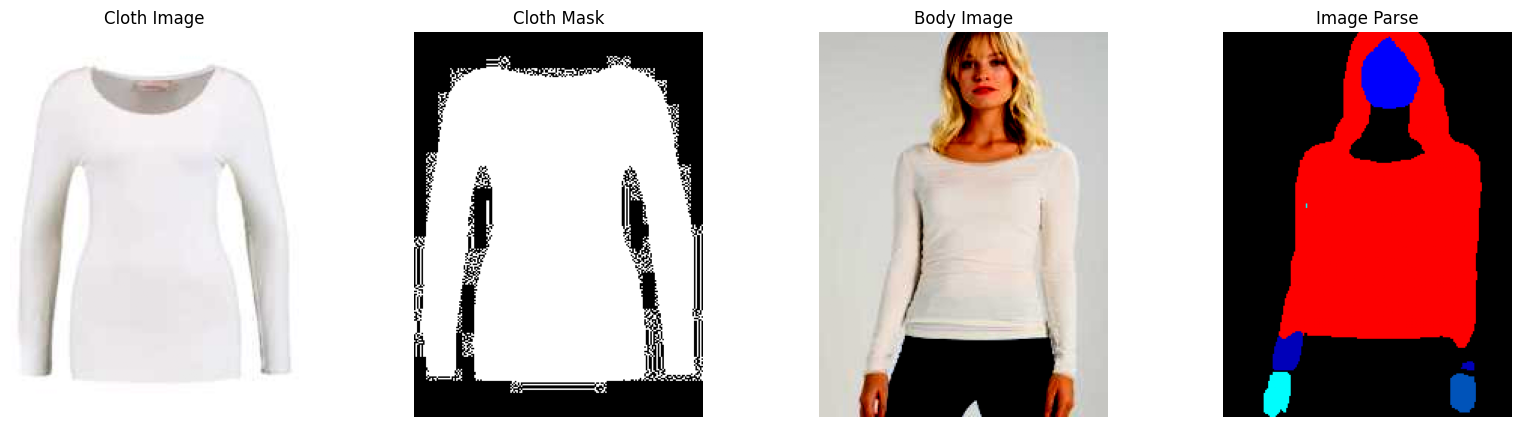

Pose Keypoints: tensor([[108.5984,  28.3927,   0.8881],
        [110.8661,  84.7127,   0.6282],
        [ 64.5039,  85.4109,   0.6060],
        [ 56.4409, 150.5745,   0.5192],
        [ 38.8032, 223.8836,   0.6742],
        [156.2205,  85.6436,   0.5669],
        [159.2441, 154.0655,   0.5168],
        [163.5276, 224.1164,   0.6239],
        [ 75.0866, 207.1273,   0.2588],
        [  0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000],
        [130.2677, 208.2909,   0.2686],
        [  0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000],
        [ 99.7795,  21.1782,   0.9522],
        [118.1732,  20.2473,   0.9498],
        [ 90.4567,  30.4873,   0.7933],
        [130.7717,  27.9273,   0.7088]])


In [77]:
def show_sample(dataset, idx):
    sample = dataset[idx]

    cloth_image = sample['cloth_image'].permute(1, 2, 0).numpy()  # [C, H, W] to [H, W, C]
    cloth_mask = sample['cloth_mask'].squeeze(0).numpy()  # Remove channel dimension
    body_image = sample['body_image'].permute(1, 2, 0).numpy()  # [C, H, W] to [H, W, C]
    # image_parse = sample['image_parse'].squeeze(0).numpy()  # Remove channel dimension for mask
    # if wanna to load image_parse as 3 channel
    image_parse = sample['image_parse'].permute(1, 2, 0).numpy()  # [C, H, W] to [H, W, C]
    pose_keypoints = sample['pose_keypoints']  # Pose keypoints are tensors

    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    axs[0].imshow(cloth_image)
    axs[0].set_title('Cloth Image')

    axs[1].imshow(cloth_mask, cmap='gray')
    axs[1].set_title('Cloth Mask')

    axs[2].imshow(body_image)
    axs[2].set_title('Body Image')

    # axs[3].imshow(image_parse, cmap='gray')
    # if wanna to load image_parse as 3 channel
    axs[3].imshow(image_parse)
    axs[3].set_title('Image Parse')

    for ax in axs:
        ax.axis('off')

    plt.show()

    print("Pose Keypoints:", pose_keypoints)

# Visualize a sample from the train dataset
show_sample(train_dataset, idx=0)

## Model Architecture Design

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

### Geometric Matching Module (GMM)

In [22]:
class GMM(nn.Module):
    """
    Geometric Matching Module (GMM) that warps the cloth image to match the body image
    using a Spatial Transformer Network (STN) with Thin-Plate Spline (TPS) transformation.

    Args:
        None

    Input:
        body_image (Tensor): The body image of the person (batch_size, 3, H, W)
        cloth_image (Tensor): The cloth image to be warped (batch_size, 3, H, W)

    Output:
        warped_cloth (Tensor): The cloth image warped to fit the body (batch_size, 3, H, W)
    """
    def __init__(self):
        super(GMM, self).__init__()

        # Feature extraction layers for body and cloth images
        # Shared convolutional layers for both inputs
        self.extraction = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3),  # Output: (batch_size, 64, H, W)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Downsample
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),  # Output: (batch_size, 128, H/2, W/2)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Downsample
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),  # Output: (batch_size, 256, H/4, W/4)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Downsample
        )

        # Thin-Plate Spline (TPS) transformation module
        # Fully connected layers to predict affine transformation matrix
        self.tps = nn.Sequential(
            nn.Linear(256 * 32 * 24, 512),  # Input size depends on the image size and feature map size
            nn.ReLU(),
            nn.Linear(512, 6)  # Predicts 6 parameters for affine transformation
        )

    def forward(self, body_image, cloth_image):
        # Extract features from body and cloth images
        body_features = self.extraction(body_image)
        cloth_features = self.extraction(cloth_image)

        # Flatten the feature maps to feed into the fully connected layers
        body_flatten = body_features.view(body_features.size(0), -1)
        cloth_flatten = cloth_features.view(cloth_features.size(0), -1)

        # Predict transformation matrix (theta)
        theta = self.tps(body_flatten)

        # Reshape theta to a 2x3 affine transformation matrix
        theta = theta.view(-1, 2, 3)

        # Create a grid for warping the cloth image
        grid = F.affine_grid(theta, cloth_image.size())

        # Warp the cloth image using the grid
        warped_cloth = F.grid_sample(cloth_image, grid)

        return warped_cloth


### UNet for Segmentation

In [62]:
class SegNet(nn.Module):
    """
    UNet-based segmentation network that generates a segmentation mask for the body.
    The input consists of the body image and the warped cloth image, and the output is a binary mask
    indicating where the clothing should appear on the person.

    Args:
        input_channels (int): Number of input channels, including the body image and warped cloth
        output_channels (int): Number of output channels, typically 1 for binary mask

    Input:
        x (Tensor): Concatenated input tensor of the body image and warped cloth (batch_size, input_channels, H, W)

    Output:
        mask (Tensor): Segmentation mask for the body (batch_size, 1, H, W)
    """
    def __init__(self, input_channels=6, output_channels=1):
        super(SegNet, self).__init__()

        # Encoder layers (downsampling path)
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),  # (batch_size, 64, H/2, W/2)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # (batch_size, 128, H/4, W/4)
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # (batch_size, 256, H/8, W/8)
            nn.ReLU()
        )

        # Decoder layers (upsampling path)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # (batch_size, 128, H/4, W/4)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # (batch_size, 64, H/2, W/2)
            nn.ReLU(),
            nn.ConvTranspose2d(64, output_channels, kernel_size=4, stride=2, padding=1),  # (batch_size, 1, H, W)
            nn.Sigmoid()  # Sigmoid to normalize output to [0, 1] for mask
        )

    def forward(self, x):
        # Pass input through encoder and decoder
        x = self.encoder(x)
        x = self.decoder(x)
        return x


### Composition Network

In [68]:
class CompNet(nn.Module):
    """
    Composition Network that combines the body image, warped cloth, and segmentation mask
    to produce the final try-on result (person wearing the new cloth).

    Args:
        None

    Input:
        body_image (Tensor): The body image of the person (batch_size, 3, H, W)
        warped_cloth (Tensor): The warped cloth image (batch_size, 3, H, W)
        segmentation_mask (Tensor): The segmentation mask indicating clothing regions (batch_size, 1, H, W)

    Output:
        output (Tensor): The final composite image (batch_size, 3, H, W)
    """
    def __init__(self):
        super(CompNet, self).__init__()

        # Composition layers that combine body image, warped cloth, and mask
        self.network = nn.Sequential(
            nn.Conv2d(7, 64, kernel_size=4, stride=2, padding=1),  # (batch_size, 64, H/2, W/2)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # (batch_size, 128, H/4, W/4)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # (batch_size, 64, H/2, W/2)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),  # (batch_size, 3, H, W)
            nn.Tanh()  # Final output in range [-1, 1] for RGB image
        )

    def forward(self, body_image, warped_cloth, segmentation_mask):
        # Concatenate body image, warped cloth, and segmentation mask along the channel dimension
        input_tensor = torch.cat([body_image, warped_cloth, segmentation_mask], dim=1)

        # Pass through the composition network
        output = self.network(input_tensor)
        return output


## Training the Virtual Try-On Model

### Loss Functions

In [25]:
import torch.nn.functional as F
from torchvision import models

In [64]:
# L1 Loss for warping
def warp_loss(warped_cloth, target_cloth):
    """
    Compute L1 loss between warped cloth and target cloth.

    Args:
        warped_cloth (Tensor): Warped cloth image from GMM (batch_size, 3, H, W)
        target_cloth (Tensor): Ground truth cloth image (batch_size, 3, H, W)

    Returns:
        loss (Tensor): L1 loss value
    """
    return F.l1_loss(warped_cloth, target_cloth)


# Cross-Entropy Loss for segmentation
def segmentation_loss(pred_mask, target_mask):
    """
    Compute Cross-Entropy loss for segmentation mask.

    Args:
        pred_mask (Tensor): Predicted segmentation mask (batch_size, 1, H, W)
        target_mask (Tensor): Ground truth segmentation mask (batch_size, 1, H, W)

    Returns:
        loss (Tensor): Cross-Entropy loss value
    """
    return F.binary_cross_entropy(pred_mask, target_mask)


# Perceptual Loss using a pre-trained VGG model
class PerceptualLoss(nn.Module):
    """
    Perceptual loss compares high-level features extracted from a pre-trained VGG model.
    This helps improve the visual quality of the final composite image.

    Args:
        None
    """
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg19(pretrained=True).features[:16].eval()  # Use the first few layers of VGG19
        for param in vgg.parameters():
            param.requires_grad = False  # Freeze VGG parameters
        self.vgg = vgg

    def forward(self, pred_img, target_img):
        # Normalize the images for VGG
        pred_img = (pred_img + 1) / 2  # Normalize to [0, 1]
        target_img = (target_img + 1) / 2
        features_pred = self.vgg(pred_img)
        features_target = self.vgg(target_img)
        perceptual_loss = F.l1_loss(features_pred, features_target)
        return perceptual_loss


### Optimization

In [27]:
import torch.optim as optim

In [65]:
# Define the optimizers for each component of the model
def create_optimizers(gmm, seg_net, comp_net, learning_rate=1e-4):
    """
    Create optimizers for each network component (GMM, Segmentation, and Composition networks).

    Args:
        gmm (nn.Module): GMM network
        seg_net (nn.Module): Segmentation network
        comp_net (nn.Module): Composition network
        learning_rate (float): Learning rate for the optimizers

    Returns:
        optimizers (tuple): Optimizers for GMM, SegNet, and CompNet
    """
    gmm_optimizer = optim.Adam(gmm.parameters(), lr=learning_rate)
    seg_optimizer = optim.Adam(seg_net.parameters(), lr=learning_rate)
    comp_optimizer = optim.Adam(comp_net.parameters(), lr=learning_rate)

    return gmm_optimizer, seg_optimizer, comp_optimizer


### Training the Model and Saving the Checkpoints

In [38]:
import os
import torch

In [78]:
def train_vton_and_save(gmm, seg_net, comp_net, dataloader, num_epochs=20, device='cuda', save_dir='./model_checkpoints'):
    """
    Training loop for the Virtual Try-On model with model saving functionality.

    Args:
        gmm (nn.Module): GMM network
        seg_net (nn.Module): Segmentation network
        comp_net (nn.Module): Composition network
        dataloader (DataLoader): DataLoader for training data
        num_epochs (int): Number of epochs for training
        device (str): Device to use for training ('cuda' or 'cpu')
        save_dir (str): Directory to save the trained models

    Returns:
        None
    """
    # Create the save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    # Move models to the device
    gmm.to(device)
    seg_net.to(device)
    comp_net.to(device)

    # Loss functions
    perceptual_loss_fn = PerceptualLoss().to(device)

    # Create optimizers
    gmm_optimizer, seg_optimizer, comp_optimizer = create_optimizers(gmm, seg_net, comp_net)

    for epoch in range(num_epochs):
        gmm.train()
        seg_net.train()
        comp_net.train()

        for batch in dataloader:
            body_image = batch['body_image'].to(device)
            cloth_image = batch['cloth_image'].to(device)
            cloth_mask = batch['cloth_mask'].to(device)
            image_parse = batch['image_parse'].to(device)

            # Step 1: Warping the cloth with GMM
            warped_cloth = gmm(body_image, cloth_image)
            warp_l1 = warp_loss(warped_cloth, cloth_image)

            # Step 2: Generating the segmentation mask
            seg_input = torch.cat([body_image, warped_cloth], dim=1)
            pred_mask = seg_net(seg_input)
            seg_loss = segmentation_loss(pred_mask, cloth_mask)

            # Step 3: Composition of final image
            composite_img = comp_net(body_image, warped_cloth, pred_mask)

            # Perceptual loss to ensure high visual quality
            perceptual_loss = perceptual_loss_fn(composite_img, image_parse)

            # Total loss
            total_loss = warp_l1 + seg_loss + perceptual_loss

            # Backpropagation and optimization
            gmm_optimizer.zero_grad()
            seg_optimizer.zero_grad()
            comp_optimizer.zero_grad()

            total_loss.backward()

            gmm_optimizer.step()
            seg_optimizer.step()
            comp_optimizer.step()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss.item():.4f}")

        # Save model checkpoints after each epoch
        torch.save(gmm.state_dict(), os.path.join(save_dir, f'gmm_epoch_{epoch+1}.pth'))
        torch.save(seg_net.state_dict(), os.path.join(save_dir, f'seg_net_epoch_{epoch+1}.pth'))
        torch.save(comp_net.state_dict(), os.path.join(save_dir, f'comp_net_epoch_{epoch+1}.pth'))

    print("Training complete! Models saved in:", save_dir)


#### Training loop

In [39]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

 We do not run these two cells if we train this model once

In [79]:
# Instantiate the model components (GMM, SegNet, CompNet)
gmm = GMM().to(device)
seg_net = SegNet().to(device)
comp_net = CompNet().to(device)

In [ ]:
# Train the model for the first phase (e.g., 10 epochs)
train_vton_and_save(gmm, seg_net, comp_net, dataloader=train_loader, num_epochs=10, device=device, save_dir='./model_checkpoints')

#### Saving Optimizer States

In [ ]:
# Save model and optimizer state for resuming training later
torch.save({
    'epoch': epoch + 1,
    'gmm_state_dict': gmm.state_dict(),
    'seg_net_state_dict': seg_net.state_dict(),
    'comp_net_state_dict': comp_net.state_dict(),
    'gmm_optimizer_state_dict': gmm_optimizer.state_dict(),
    'seg_optimizer_state_dict': seg_optimizer.state_dict(),
    'comp_optimizer_state_dict': comp_optimizer.state_dict(),
    'loss': total_loss,
}, os.path.join(save_dir, f'checkpoint_epoch_{epoch+1}.pth'))

#### Loading the Model for Future Training

In [ ]:
# Load the model for further training

# Re-instantiate the model components
gmm = GMM().to(device)
seg_net = SegNet().to(device)
comp_net = CompNet().to(device)

# Load the model checkpoints (from epoch 10)
gmm.load_state_dict(torch.load('./model_checkpoints/gmm_epoch_10.pth'))
seg_net.load_state_dict(torch.load('./model_checkpoints/seg_net_epoch_10.pth'))
comp_net.load_state_dict(torch.load('./model_checkpoints/comp_net_epoch_10.pth'))

# If you want to load optimizer states (assuming you saved them)
gmm_optimizer = torch.optim.Adam(gmm.parameters(), lr=0.001)  # Ensure optimizers are created first
seg_optimizer = torch.optim.Adam(seg_net.parameters(), lr=0.001)
comp_optimizer = torch.optim.Adam(comp_net.parameters(), lr=0.001)

# Load optimizer state if needed:
checkpoint = torch.load('./model_checkpoints/checkpoint_epoch_10.pth')
gmm_optimizer.load_state_dict(checkpoint['gmm_optimizer_state_dict'])
seg_optimizer.load_state_dict(checkpoint['seg_optimizer_state_dict'])
comp_optimizer.load_state_dict(checkpoint['comp_optimizer_state_dict'])


In [ ]:
# Continue training for more epochs (e.g., 10 more epochs)
train_vton_and_save(gmm, seg_net, comp_net, dataloader=train_loader, num_epochs=10, device=device, save_dir='./model_checkpoints')

## Evaluation and Inference

### Evaluation Function

In [ ]:
def evaluate_vton(gmm, seg_net, comp_net, test_loader, device='cuda'):
    """
    Evaluate the Virtual Try-On model on the test set.

    Args:
        gmm (nn.Module): GMM network
        seg_net (nn.Module): Segmentation network
        comp_net (nn.Module): Composition network
        test_loader (DataLoader): DataLoader for test data
        device (str): Device to use for evaluation ('cuda' or 'cpu')

    Returns:
        None
    """
    # Set models to evaluation mode
    gmm.eval()
    seg_net.eval()
    comp_net.eval()

    total_warp_loss = 0.0
    total_seg_loss = 0.0
    total_perceptual_loss = 0.0
    perceptual_loss_fn = PerceptualLoss().to(device)

    with torch.no_grad():
        for batch in test_loader:
            body_image = batch['body_image'].to(device)
            cloth_image = batch['cloth_image'].to(device)
            cloth_mask = batch['cloth_mask'].to(device)
            image_parse = batch['image_parse'].to(device)

            # Step 1: Warping the cloth with GMM
            warped_cloth = gmm(body_image, cloth_image)
            warp_l1 = warp_loss(warped_cloth, cloth_image)
            total_warp_loss += warp_l1.item()

            # Step 2: Generating the segmentation mask
            seg_input = torch.cat([body_image, warped_cloth], dim=1)  # Concatenate inputs for SegNet
            pred_mask = seg_net(seg_input)
            seg_loss = segmentation_loss(pred_mask, cloth_mask)
            total_seg_loss += seg_loss.item()

            # Step 3: Composition of final image
            composite_img = comp_net(body_image, warped_cloth, pred_mask)

            # Perceptual loss
            perceptual_loss = perceptual_loss_fn(composite_img, image_parse)
            total_perceptual_loss += perceptual_loss.item()

        # Calculate average losses over the entire test set
        avg_warp_loss = total_warp_loss / len(test_loader)
        avg_seg_loss = total_seg_loss / len(test_loader)
        avg_perceptual_loss = total_perceptual_loss / len(test_loader)

    print(f"Average Warp Loss: {avg_warp_loss:.4f}")
    print(f"Average Segmentation Loss: {avg_seg_loss:.4f}")
    print(f"Average Perceptual Loss: {avg_perceptual_loss:.4f}")


In [ ]:
# Evaluate the model
evaluate_vton(gmm, seg_net, comp_net, test_loader, device=device)

### Inference and Visualization

In [ ]:
def visualize_vton_results(gmm, seg_net, comp_net, test_loader, num_examples=5, device='cuda'):
    """
    Perform inference with the trained Virtual Try-On model and visualize the results.

    Args:
        gmm (nn.Module): GMM network
        seg_net (nn.Module): Segmentation network
        comp_net (nn.Module): Composition network
        test_loader (DataLoader): DataLoader for test data
        num_examples (int): Number of examples to visualize
        device (str): Device to use for inference ('cuda' or 'cpu')

    Returns:
        None
    """
    # Set models to evaluation mode
    gmm.eval()
    seg_net.eval()
    comp_net.eval()

    # Get a batch of test data
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            if i >= num_examples:
                break

            body_image = batch['body_image'].to(device)
            cloth_image = batch['cloth_image'].to(device)
            cloth_mask = batch['cloth_mask'].to(device)

            # Step 1: Warping the cloth with GMM
            warped_cloth = gmm(body_image, cloth_image)

            # Step 2: Generating the segmentation mask
            seg_input = torch.cat([body_image, warped_cloth], dim=1)
            pred_mask = seg_net(seg_input)

            # Step 3: Composition of final image
            composite_img = comp_net(body_image, warped_cloth, pred_mask)

            # Convert tensors to numpy arrays for visualization
            body_image_np = body_image.cpu().numpy().transpose(0, 2, 3, 1)
            cloth_image_np = cloth_image.cpu().numpy().transpose(0, 2, 3, 1)
            warped_cloth_np = warped_cloth.cpu().numpy().transpose(0, 2, 3, 1)
            composite_img_np = composite_img.cpu().numpy().transpose(0, 2, 3, 1)

            # Visualize the results
            fig, axs = plt.subplots(1, 4, figsize=(12, 6))

            axs[0].imshow((body_image_np[0] * 0.5 + 0.5))  # Denormalize to [0, 1]
            axs[0].set_title('Body Image')

            axs[1].imshow((cloth_image_np[0] * 0.5 + 0.5))  # Denormalize to [0, 1]
            axs[1].set_title('Original Cloth')

            axs[2].imshow((warped_cloth_np[0] * 0.5 + 0.5))  # Denormalize to [0, 1]
            axs[2].set_title('Warped Cloth')

            axs[3].imshow((composite_img_np[0] * 0.5 + 0.5))  # Denormalize to [0, 1]
            axs[3].set_title('Final Try-On')

            for ax in axs:
                ax.axis('off')

            plt.show()


In [ ]:
# Visualize results of model
visualize_vton_results(gmm, seg_net, comp_net, test_loader, num_examples=5, device=device)